In [1]:
import osmnx as ox
import matplotlib.pyplot as plt
import geopandas as gp
from geopandas import GeoDataFrame
import networkx as nx
import os.path
from os import path
import pathlib
import pandas as pd
ox.config(log_console=True, use_cache=True)

In [2]:
speed_df = pd.read_csv('../data/Uber_speeds/movement-speeds-hourly-berlin-2020-1.csv')
speed_df

,year,month,day,hour,utc_timestamp,segment_id,start_junction_id,end_junction_id,osm_way_id,osm_start_node_id,osm_end_node_id,speed_kph_mean,speed_kph_stddev
0,2020,1,15,22,2020-01-15T21:00:00.000Z,277640ca389fc7f0fc8a583386e6063df80485f0,ad26106a25d52c3409bd0165f05de3047a4e96b5,9c00a9375aeaba9c08f4f2fd507cc1808ba83b89,9932085,81398215,1236497752,35.532,4.510
1,2020,1,27,20,2020-01-27T19:00:00.000Z,277640ca389fc7f0fc8a583386e6063df80485f0,ad26106a25d52c3409bd0165f05de3047a4e96b5,9c00a9375aeaba9c08f4f2fd507cc1808ba83b89,9932085,81398215,1236497752,33.747,1.482
2,2020,1,15,19,2020-01-15T18:00:00.000Z,277640ca389fc7f0fc8a583386e6063df80485f0,ad26106a25d52c3409bd0165f05de3047a4e96b5,9c00a9375aeaba9c08f4f2fd507cc1808ba83b89,9932085,81398215,1236497752,41.433,9.934
3,2020,1,21,21,2020-01-21T20:00:00.000Z,277640ca389fc7f0fc8a583386e6063df80485f0,ad26106a25d52c3409bd0165f05de3047a4e96b5,9c00a9375aeaba9c08f4f2fd507cc1808ba83b89,9932085,81398215,1236497752,35.808,4.182
4,2020,1,25,21,2020-01-25T20:00:00.000Z,d0034ae2336f81ef5933a211f2ce2d979f0aff2a,66081f9fe2860af2a498e1248334cb51d6ea5073,9c00a9375aeaba9c08f4f2fd507cc1808ba83b89,9932085,1236497729,1236497752,41.691,5.543
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2780210,2020,1,26,23,2020-01-26T22:00:00.000Z,46ec6887faf8d9d9d26fb72f575ae064f38d65dd,3c358a996e6db9c97f327284d8c6cd7355ddc03c,8e9f29c18cf04f6bac662cd03017619dfd68e0ee,385627960,312370453,29858455,51.693,7.077
2780211,2020,1,26,3,2020-01-26T02:00:00.000Z,46ec6887faf8d9d9d26fb72f575ae064f38d65dd,3c358a996e6db9c97f327284d8c6cd7355ddc03c,8e9f29c18cf04f6bac662cd03017619dfd68e0ee,385627960,312370453,29858455,47.522,23.820
2780212,2020,1,1,3,2020-01-01T02:00:00.000Z,46ec6887faf8d9d9d26fb72f575ae064f38d65dd,3c358a996e6db9c97f327284d8c6cd7355ddc03c,8e9f29c18cf04f6bac662cd03017619dfd68e0ee,385627960,312370453,29858455,35.562,23.883
2780213,2020,1,1,5,2020-01-01T04:00:00.000Z,46ec6887faf8d9d9d26fb72f575ae064f38d65dd,3c358a996e6db9c97f327284d8c6cd7355ddc03c,8e9f29c18cf04f6bac662cd03017619dfd68e0ee,385627960,312370453,29858455,39.424,24.362


In [4]:
G = ox.graph_from_place('Berlin, DE', network_type='drive', )

In [8]:
osm_id_df = speed_df[['osm_way_id','osm_start_node_id','osm_end_node_id','speed_kph_mean']]
osm_id_df = osm_id_df.groupby(['osm_start_node_id','osm_end_node_id']).mean().reset_index()
in_graph = [ id_start in G.nodes and id_end in G.nodes and id_end in G[id_start].keys() for id_start, id_end in zip(osm_id_df['osm_start_node_id'], osm_id_df['osm_end_node_id'])]

osm_id_df = osm_id_df[in_graph]

#osm_id_df = osm_id_df[:100]

osm_id_df['osm_segment'] = [G.edges[id_start,id_end,0] for id_start,id_end in zip(osm_id_df['osm_start_node_id'], osm_id_df['osm_end_node_id'])]

has_geometry = ['geometry' in way.keys() for way in osm_id_df['osm_segment']]
osm_id_df = osm_id_df[has_geometry]

geometry = [row['geometry'] for row in osm_id_df['osm_segment']]

geo_df = GeoDataFrame(osm_id_df['speed_kph_mean'], geometry=geometry)
geo_df.to_file("../results/uber_mean_speed.geojson", driver='GeoJSON')

In [142]:
26904555 in G.nodes

True

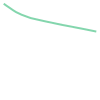

In [179]:
G.edges[172539,34694265,0]['geometry']

In [152]:
27587520 in G[26904555].keys()

True

In [ ]:
#zip the coordinates into a point object and convert to a GeoData Frame
geometry = [Point(xy) for xy in zip(df.X, df.Y)]
geo_df = GeoDataFrame(df, geometry=geometry)

# aggregate these points with the GrouBy
geo_df = geo_df.groupby(['track_seg_point_id', 'Hour'])['geometry'].apply(lambda x: LineString(x.tolist()))
geo_df = GeoDataFrame(geo_df, geometry='geometry')

In [ ]:
print geo_df